In [4]:
import pandas as pd

In [5]:
def macd(price_series, short_window=5, long_window=34, signal_window=5):
    # 1. Calculate EMAs
    short_ema = price_series.ewm(span=short_window, adjust=False).mean()
    long_ema = price_series.ewm(span=long_window, adjust=False).mean()

    # 2. MACD Line
    macd_line = short_ema - long_ema

    # 3. Signal Line (EMA of MACD)
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    # 4. Histogram (MACD - Signal)
    macd_hist = macd_line - signal_line

    # Return as a DataFrame
    return pd.DataFrame({
        "MACD": macd_line,
        "Signal Line": signal_line,
        "Histogram": macd_hist
    })

In [6]:
def weighted_moving_average(series, period):
    weights = np.arange(1, period + 1)
    return series.rolling(period).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

def hull_moving_average(series, period):
    half_length = int(period / 2)
    sqrt_length = int(np.sqrt(period))

    wma_half = weighted_moving_average(series, half_length)
    wma_full = weighted_moving_average(series, period)

    hull_series = 2 * wma_half - wma_full
    hma = weighted_moving_average(hull_series, sqrt_length)

    return hma

In [7]:
def process_stock_data(csv_url):
    # Load and prepare data
    df = pd.read_csv(csv_url)
    df['Open time'] = pd.to_datetime(df['Open time'])  # Ensure datetime format

    df['15minReturn'] = df['Close'] / df['Close'].shift(1) - 1
    df['15minrange'] = df['High'] - df['Low']
    df['Volchange'] = df['Volume'] / (df['Volume'].shift(1) + 1e-8) - 1

    # Calculate MACD and join to original DataFrame
    macd_r = macd(df["15minReturn"]).add_prefix("Ret_")
    df = df.join(macd_r)
    
    macd_v = macd(df["Volchange"]).add_prefix("Vol_")
    df = df.join(macd_v)

    df['HMA_100_Volume'] = hull_moving_average(df['Volume'], 100)
    df['HMA_200_Volume'] = hull_moving_average(df['Volume'], 200)

    # 5-day rolling volatility (daily returns)
    df['Volatility_5'] = df['15minReturn'].rolling(window=5).std()

    # 10-day rolling volatility
    df['Volatility_10'] = df['15minReturn'].rolling(window=10).std()

    # 20-day rolling volatility
    df['Volatility_20'] = df['15minReturn'].rolling(window=20).std()
    df['Volatility_35'] = df['15minReturn'].rolling(window=35).std()
    # Volume Z-score over past 20 days
    df['Volume_Z'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()

    # Price Z-score (on Close) over past 20 days
    df['Price_Z'] = (df['Close'] - df['Close'].rolling(20).mean()) / df['Close'].rolling(20).std()

    # Return Z-score over past 20 days
    df['Return_Z'] = (df['15minReturn'] - df['15minReturn'].rolling(20).mean()) / df['15minReturn'].rolling(20).std()

    ma_20 = df['Close'].rolling(20).mean()
    ma_std_20 = df['Close'].rolling(20).std()
    df['Z_Close_MA_20'] = (df['Close'] - ma_20) / ma_std_20

    df.dropna(inplace=True)
    
    return df

In [8]:
import numpy as np

def generate_volatility_labels(df, lookahead=12, n_classes=3):
    df = df.copy()

    # Compute log returns
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Calculate rolling future volatility (std of log returns)
    df['future_vol'] = (
        df['log_return']
        .shift(-lookahead + 1)  # Shift so we're looking forward
        .rolling(window=lookahead)
        .std()
    )

    # Drop rows with NaNs due to rolling and shifting
    df = df.iloc[:-lookahead]

    # Quantile binning to create classes
    df['volatility_class'] = pd.qcut(
        df['future_vol'],
        q=n_classes,
        labels=range(n_classes)
    )

    return df


In [9]:
df = process_stock_data("/Users/rong/Desktop/btc_15m_data_2018_to_2025.csv")
df = generate_volatility_labels(df, lookahead=12, n_classes=3)

In [10]:
df.dropna()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,Volatility_10,Volatility_20,Volatility_35,Volume_Z,Price_Z,Return_Z,Z_Close_MA_20,log_return,future_vol,volatility_class
223,2018-01-03 07:45:00,15158.57,15231.51,15135.90,15170.00,172.989883,2018-01-03 07:59:59.999,2.626280e+06,1515,89.399478,...,0.006533,0.006506,0.005784,-0.815326,0.940688,0.015806,0.940688,0.000659,0.009372,2
224,2018-01-03 08:00:00,15170.00,15172.99,14910.00,14975.00,257.622957,2018-01-03 08:14:59.999,3.875107e+06,2153,160.337093,...,0.007777,0.006694,0.006233,0.880580,-0.572263,-1.826825,-0.572263,-0.012938,0.009560,2
225,2018-01-03 08:15:00,14974.98,15050.00,14900.00,14950.00,241.666106,2018-01-03 08:29:59.999,3.621941e+06,1927,143.733039,...,0.007772,0.006619,0.006243,0.603070,-0.712309,-0.183102,-0.712309,-0.001671,0.009695,2
226,2018-01-03 08:30:00,14968.02,15113.49,14950.00,15086.00,201.905635,2018-01-03 08:44:59.999,3.039620e+06,2006,129.801492,...,0.008272,0.006802,0.006359,-0.167519,0.363250,1.292182,0.363250,0.009056,0.009696,2
227,2018-01-03 08:45:00,15086.00,15113.49,15000.00,15002.59,194.740060,2018-01-03 08:59:59.999,2.934303e+06,1963,119.701303,...,0.008311,0.006312,0.006402,-0.247504,-0.432173,-0.976801,-0.432173,-0.005544,0.010265,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260956,2025-06-16 20:00:00,108652.01,108693.21,108428.00,108646.31,241.133820,2025-06-16 20:14:59.999,2.617901e+07,38180,130.196620,...,0.001560,0.001349,0.001529,0.935354,1.506242,-0.398364,1.506242,-0.000052,0.003530,2
260957,2025-06-16 20:15:00,108646.30,108648.68,108509.66,108626.77,93.391940,2025-06-16 20:29:59.999,1.013982e+07,19332,39.826400,...,0.001515,0.001309,0.001493,-0.924183,1.316000,-0.541088,1.316000,-0.000180,0.003586,2
260958,2025-06-16 20:30:00,108626.77,108757.32,108559.89,108737.31,87.088030,2025-06-16 20:44:59.999,9.461555e+06,14678,53.431900,...,0.001473,0.001314,0.001484,-0.970460,1.408247,0.356865,1.408247,0.001017,0.003632,2
260959,2025-06-16 20:45:00,108737.31,108849.77,108558.13,108782.68,144.274680,2025-06-16 20:59:59.999,1.568019e+07,30030,68.689790,...,0.001468,0.001250,0.001459,-0.267263,1.381658,-0.169363,1.381658,0.000417,0.003690,2


In [11]:
df.reset_index(inplace=True)

In [12]:
del df['index']

In [13]:
df

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,Volatility_10,Volatility_20,Volatility_35,Volume_Z,Price_Z,Return_Z,Z_Close_MA_20,log_return,future_vol,volatility_class
0,2018-01-03 05:00:00,15031.01,15094.00,14900.00,15038.62,240.017596,2018-01-03 05:14:59.999,3.599147e+06,1587,149.584611,...,0.006822,0.006111,0.007776,0.562947,0.997622,0.045036,0.997622,NaN,NaN,NaN
1,2018-01-03 05:15:00,15033.87,15095.00,14990.00,15063.00,227.757728,2018-01-03 05:29:59.999,3.426303e+06,1273,130.665153,...,0.006828,0.006008,0.007568,0.291319,1.067851,0.140565,1.067851,0.001620,NaN,NaN
2,2018-01-03 05:30:00,15063.00,15114.98,15016.05,15016.16,180.635523,2018-01-03 05:44:59.999,2.724604e+06,1379,126.278703,...,0.005814,0.005882,0.007201,-0.592474,0.648957,-0.683550,0.648957,-0.003114,NaN,NaN
3,2018-01-03 05:45:00,15051.93,15100.00,14980.88,14988.00,211.972330,2018-01-03 05:59:59.999,3.186693e+06,1795,128.506485,...,0.005655,0.005911,0.006954,-0.042339,0.369828,-0.441445,0.369828,-0.001877,NaN,NaN
4,2018-01-03 06:00:00,14980.89,15000.00,14889.50,14959.90,226.748359,2018-01-03 06:14:59.999,3.388053e+06,2143,123.530112,...,0.005342,0.005916,0.005868,0.261584,0.097723,-0.400864,0.097723,-0.001877,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260744,2025-06-16 20:00:00,108652.01,108693.21,108428.00,108646.31,241.133820,2025-06-16 20:14:59.999,2.617901e+07,38180,130.196620,...,0.001560,0.001349,0.001529,0.935354,1.506242,-0.398364,1.506242,-0.000052,0.003530,2
260745,2025-06-16 20:15:00,108646.30,108648.68,108509.66,108626.77,93.391940,2025-06-16 20:29:59.999,1.013982e+07,19332,39.826400,...,0.001515,0.001309,0.001493,-0.924183,1.316000,-0.541088,1.316000,-0.000180,0.003586,2
260746,2025-06-16 20:30:00,108626.77,108757.32,108559.89,108737.31,87.088030,2025-06-16 20:44:59.999,9.461555e+06,14678,53.431900,...,0.001473,0.001314,0.001484,-0.970460,1.408247,0.356865,1.408247,0.001017,0.003632,2
260747,2025-06-16 20:45:00,108737.31,108849.77,108558.13,108782.68,144.274680,2025-06-16 20:59:59.999,1.568019e+07,30030,68.689790,...,0.001468,0.001250,0.001459,-0.267263,1.381658,-0.169363,1.381658,0.000417,0.003690,2


In [14]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [15]:
cap_value = 155.31
df['Volchange'] = df['Volchange'].clip(upper=cap_value)


In [17]:
from fastai.tabular.all import *


In [18]:
trn_df = df.iloc[:200000].copy().reset_index(drop=True)
val_df = df.iloc[200000:230000].copy().reset_index(drop=True)
test_df = df.iloc[230000:].copy().reset_index(drop=True)

procs = [Categorify, FillMissing, Normalize]
conts = ['15minReturn', '15minrange', 'Volchange', 'Volatility_5', 'Volatility_10', 
         'Volatility_20', 'Volatility_35', 'Volume_Z', 'Price_Z', 'Return_Z', 
         'Z_Close_MA_20', 'Vol_Histogram', 'Ret_Histogram', 'HMA_100_Volume', 'HMA_200_Volume']
y = "volatility_class"


In [19]:
trn_df.dropna(inplace=True)
val_df.dropna(inplace=True)

trn_df.isna().sum()
val_df.isna().sum()

Open time                       0
Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Close time                      0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
Ignore                          0
15minReturn                     0
15minrange                      0
Volchange                       0
Ret_MACD                        0
Ret_Signal Line                 0
Ret_Histogram                   0
Vol_MACD                        0
Vol_Signal Line                 0
Vol_Histogram                   0
HMA_100_Volume                  0
HMA_200_Volume                  0
Volatility_5                    0
Volatility_10                   0
Volatility_20                   0
Volatility_35                   0
Volume_Z                        0
Price_Z                         0
Return_Z      

In [20]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format

In [21]:
splits = (list(trn_df.index), list(val_df.index))

dls = TabularPandas(
    df,
    splits=splits,
    procs=[Categorify, FillMissing, Normalize],
    cont_names=['15minReturn', '15minrange', 'Volchange', 'Volatility_5', 'Volatility_10', 
         'Volatility_20', 'Volatility_35', 'Volume_Z', 'Price_Z', 'Return_Z', 
         'Z_Close_MA_20', 'Vol_Histogram', 'Ret_Histogram', 'HMA_100_Volume', 'HMA_200_Volume'],
    y_names="volatility_class",
    y_block=CategoryBlock(),
).dataloaders(path=".")


In [22]:
learn = tabular_learner(dls, metrics=accuracy, layers=[200,100])

SuggestedLRs(slide=0.009120108559727669, valley=0.0014454397605732083)

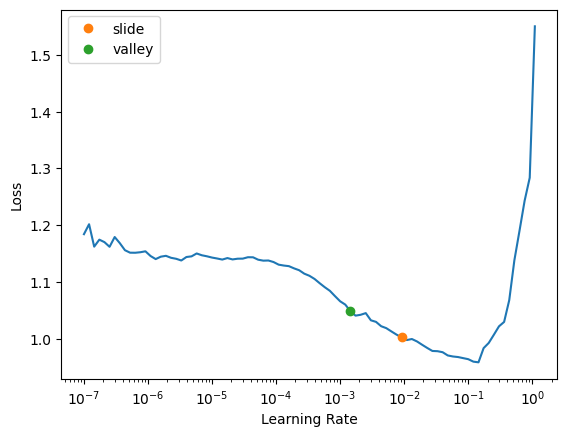

In [23]:
learn.lr_find(suggest_funcs=(slide, valley))

In [24]:
learn.fit_one_cycle(3)  # 3 epochs

epoch,train_loss,valid_loss,accuracy,time
0,0.782345,0.705841,0.670800,00:24
1,0.766267,0.683122,0.687000,00:23
2,0.743992,0.682338,0.688767,00:23


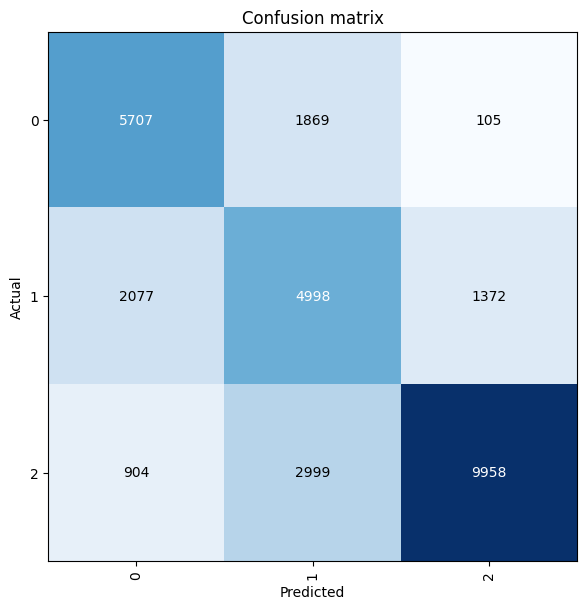

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6, 6))


In [26]:
learn.export('/Users/rong/Desktop/NS/ai001-p1/notebooks/tabular_model.pkl')


In [32]:
# Step 1: Create a TabularPandas object for test_df
to_test = TabularPandas(
    test_df,
    procs=list(dls.train.dataset.procs.fs),  # Use same processors, FIXED
    cont_names=dls.train.dataset.cont_names,  # Use same continuous features
    cat_names=dls.train.dataset.cat_names,    # Include categorical if any
    y_names="volatility_class",
    y_block=CategoryBlock()
)

# Step 2: Create a test dataloader
test_dl = learn.dls.test_dl(to_test)

# Step 3: Get predictions
preds, targs = learn.get_preds(dl=test_dl)

# Step 4: Evaluate
from sklearn.metrics import accuracy_score

pred_classes = preds.argmax(dim=1)
accuracy = accuracy_score(targs, pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")


AttributeError: columns

In [33]:
# Step 1: Create a test dataloader from raw DataFrame (FastAI will process it)
test_dl = learn.dls.test_dl(test_df)

# Step 2: Get predictions
preds, targs = learn.get_preds(dl=test_dl)

# Step 3: Evaluate
from sklearn.metrics import accuracy_score

pred_classes = preds.argmax(dim=1)
accuracy = accuracy_score(targs, pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.5485


In [37]:
from sklearn.metrics import mean_absolute_error

# Step 1: Convert class probabilities to class predictions
pred_classes = preds.argmax(dim=1)

# Step 2: Calculate MAE
mae = mean_absolute_error(targs.numpy(), pred_classes.numpy())

print(f"Test MAE: {mae:.4f}")


Test MAE: 0.4960


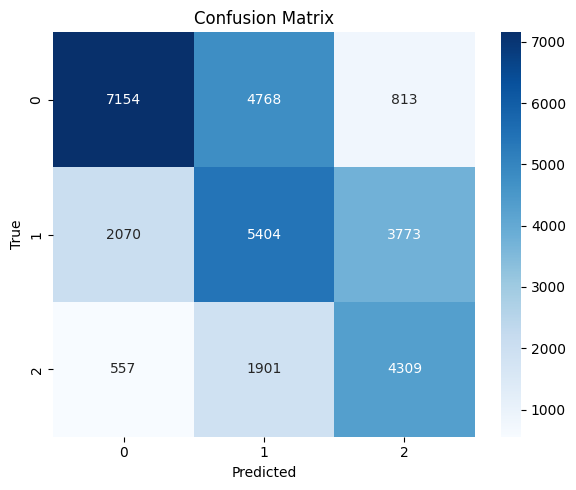

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions to class indices
pred_classes = preds.argmax(dim=1)

# Compute confusion matrix
cm = confusion_matrix(targs, pred_classes)

# Plot using seaborn for better visuals
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=learn.dls.vocab, yticklabels=learn.dls.vocab)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [38]:
mae

0.49601613060587335